In [53]:
import torch
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import pydicom
from PIL import Image
import os
import numpy as np
import scipy.ndimage as ndimage

import matplotlib.pyplot as plt

# Read image labels in mat format
import scipy.io as sio
mat_file = sio.loadmat(r"C:\Users\rasmu\OneDrive - Aarhus universitet\Bachelor\Andet\Videre arbejde\Data\Fantom 6 - Gentuity\TIFF_TO_DICOM\labels_from_unet.mat")

# Read the labels from the mat file
labels = mat_file['labels']

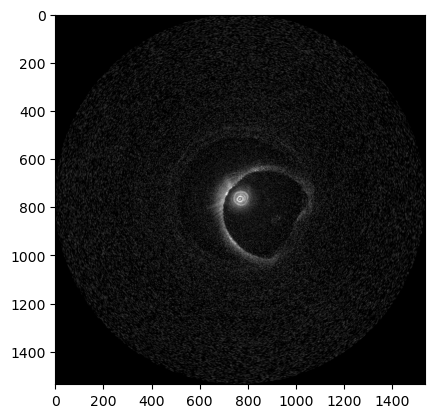

In [48]:
# Define the folder path containing TIFF images
tiff_folder_path = os.path.dirname(r"C:\Users\rasmu\OneDrive - Aarhus universitet\Bachelor\Andet\Videre arbejde\Data\Fantom 6 - Gentuity\TIFF\*.tiff")

# Read all TIFF images from the folder into an array
images = []
for i, filename in enumerate(os.listdir(tiff_folder_path)):
    if i >= 10:
        break
    if filename.endswith('.tiff') or filename.endswith('.tif'):
        img_path = os.path.join(tiff_folder_path, filename)
        img = Image.open(img_path)
        images.append(np.array(img))

# Add images to a tensor and add a second channel dimension
images = np.array(images)
images_tensor = torch.tensor(images).unsqueeze(1)

# Show the first image in the tensor
plt.imshow(images_tensor[1, 0, :, :], cmap='gray')
plt.show()

In [51]:
def augment_image(img_path):
# Read all TIFF images from the folder into an array
    images = []
    for i, filename in enumerate(os.listdir(tiff_folder_path)):
        if i >= 10: ## Change this to the number of images to augment
            break
        if filename.endswith('.tiff') or filename.endswith('.tif'):
            img_path = os.path.join(tiff_folder_path, filename)
            img = Image.open(img_path)
            p = np.random.rand()
            if p < 0.50:
                img = ndimage.minimum_filter(np.array(img), size=np.random.randint(1, 4) * 2 + 1)
            images.append(np.array(img))

    # Add images to a tensor and add a second channel dimension
    images = np.array(images)
    images_tensor = torch.tensor(images).unsqueeze(1)
    transform = v2.Compose([
        v2.RandomRotation(degrees=(0,180), expand=False, center=None, fill=0),
        v2.ColorJitter(contrast=2, brightness=1, saturation=None, hue=None)
    ])
    # For each image in the tensor, apply the data augmentation
    augmented_images = []
    for i in range(images_tensor.shape[0]):
        augmented_image = transform(images_tensor[i])
        augmented_images.append(augmented_image)

    # Convert the list of augmented images to a tensor
    augmented_images = torch.stack(augmented_images)
    return augmented_images

def save_augmented_images(augmented_images, path):
    # Save the augmented images to a folder in a given path
    # Create the folder if it does not exist
    if not os.path.exists(path):
        os.makedirs(path)
    for i in range(augmented_images.shape[0]):
        img = augmented_images[i, 0, :, :]
        img = Image.fromarray(img.numpy())
        img.save(f"{path}/augment_image_{i}.tiff")



In [52]:
augmented_images = augment_image(tiff_folder_path)

save_augmented_images(augmented_images, r"C:\Users\rasmu\OneDrive - Aarhus universitet\Bachelor\Andet\Videre arbejde\Data\Fantom 6 - Gentuity\TIFF_TO_DICOM\Augmented_images")

**Testing**

In [13]:
class RandomRotationWithLabel:
    def __init__(self, degrees, color_jitter_params=None):
        self.degrees = degrees
        self.rotation_transform = v2.RandomRotation(degrees)
        self.color_jitter = v2.ColorJitter(**color_jitter_params) if color_jitter_params else None

    def __call__(self, img, label):
        # Generate a random angle
        angle = v2.RandomRotation.get_params([-self.degrees, self.degrees])

        # Rotate image and label by the same angle
        img = v2.functional.rotate(img, angle)
        label = v2.functional.rotate(label, angle)

        # Apply ColorJitter only to the image
        if self.color_jitter:
            img = self.color_jitter(img)

        return img, label
    
# Example usage
transform = RandomRotationWithLabel(
    degrees=30,
    color_jitter_params={"brightness": 0.5, "contrast": 0.5, "saturation": 0.5, "hue": 0.2},
)

image = images_tensor[0]
label = labels[:,:,1]

# Apply the transformation
transformed_image, transformed_label = transform(image, label)

# Display the results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(transformed_image)
plt.title("Transformed Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(transformed_label)
plt.title("Transformed Label")
plt.axis("off")

plt.show()

TypeError: Functional F.rotate supports inputs of type dict_keys([<class 'torchvision.tv_tensors._image.Image'>, <class 'torch.Tensor'>, <class 'PIL.Image.Image'>, <class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'>, <class 'torchvision.tv_tensors._mask.Mask'>, <class 'torchvision.tv_tensors._video.Video'>]), but got <class 'numpy.ndarray'> instead.

In [ ]:
transform = v2.Compose([
    v2.RandomRotation(degrees=(0,180), expand=False, center=None, fill=0),
    v2.ColorJitter(contrast=2, brightness=1, saturation=None, hue=None)
])

# For each image in the tensor, apply the data augmentation
augmented_images = []
for i in range(images_tensor.shape[0]):
    augmented_image = transform(images_tensor[i])
    augmented_images.append(augmented_image)

# Convert the list of augmented images to a tensor
augmented_images = torch.stack(augmented_images)


# Plot 5 random instances of the augmented images and the original images
fig, axs = plt.subplots(5, 2, figsize=(10, 20))
for i in range(5):
    axs[i, 0].imshow(images_tensor[i].squeeze(), cmap='gray')
    axs[i, 1].imshow(augmented_images[i].squeeze(), cmap='gray')
plt.show()



In [ ]:
jitter = v2.ColorJitter(contrast=0.5, brightness=1,saturation=None, hue=None)
n_imgs = 5
jittered_imgs = [jitter(pil_image) for _ in range(n_imgs-1)]
#Plot original and jittered images
fig, ax = plt.subplots(1,n_imgs)
fig.set_size_inches(15, 5)
ax[0].imshow(tiff_images[1], cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')
for i, img in enumerate(jittered_imgs):
    ax[i+1].imshow(np.array(img), cmap='gray')
    ax[i+1].axis('off')
plt.show()

#Plot a histogram of the original and jittered images
fig, ax = plt.subplots(1,n_imgs)
fig.set_size_inches(15, 5)
ax[0].hist(tiff_images[1].ravel(), bins=64, range=[0, 128])
ax[0].set_title('Original Image')
for i, img in enumerate(jittered_imgs):
    ax[i+1].hist(np.array(img).ravel(), bins=64, range=[0, 128])
    ax[i+1].set_title('Jittered Image')
plt.show()

In [ ]:
blur = v2.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))
blur_imgs = [blur(pil_image) for _ in range(4)]
#Plot original and equalized images
fig, ax = plt.subplots(1,5)
fig.set_size_inches(15, 5)
ax[0].imshow(tiff_images[1], cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')
for i, img in enumerate(blur_imgs):
    ax[i+1].imshow(np.array(img), cmap='gray')
    ax[i+1].axis('off')
plt.show()


TypeError: Image data of dtype object cannot be converted to float

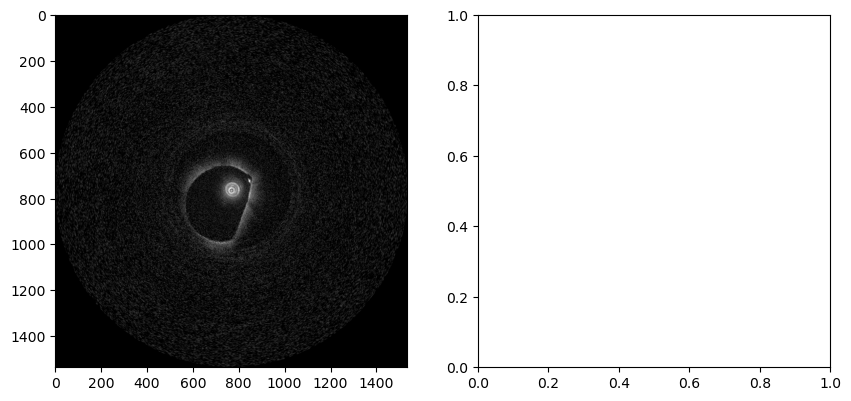

In [54]:
#Read tif img from path
img_path = r"C:\Users\rasmu\OneDrive - Aarhus universitet\Dokumenter\Biomedicinsk teknologi\2. semester\Deep Learning\Gentuity6_test.tiff"
img = Image.open(img_path)
#img = images_tensor[1, 0, :, :]

#blurrer = v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.0))
#blurred_img = blurrer(img)
resizedCrop = v2.RandomResizedCrop(size=(256, 256), scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333))
fix, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img, cmap='gray')
ax[1].imshow(resizedCrop, cmap='gray')
plt.show()